# miss-cycle-distribution

In [1]:
import os
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def gather_data(prefetchers, exp_dirs, traces):
    data = {}
    for trace in traces:
        data[trace] = {}
        for prefetcher in prefetchers:
            data[trace][prefetcher] = {}
            exp_dir = exp_dirs[prefetcher].format(trace=trace)

            for cache in ['cpu0_L1D', 'cpu0_L2C', 'LLC']:
                cache_str = cache.replace('cpu0_', '')
                cache_path = os.path.join(exp_dir, f'{cache}_memory_cycle_dist.csv')
                #print(trace, prefetcher, cache_str, cache_path)
                data[trace][prefetcher][cache_str] = pd.read_csv(cache_path, index_col='cycles')

    return data


In [3]:
exp_dirs = {
    'no': '/scratch/cluster/cmolder/pythia/degree1_baseline/memory_cycle_dists/{trace}-seed_1337/',
    'bo': '/scratch/cluster/cmolder/pythia/degree1_featureless_tuned_nozeroaction/memory_cycle_dists/{trace}-l2pf_bo_1-seed_1337/',
    'cygnus': '/scratch/cluster/cmolder/pythia/degree1_featureless_tuned_nozeroaction/memory_cycle_dists/{trace}-l2pf_cygnus_0-seed_1337/',
}
for i in range(1, 64):
    exp_dirs[f'+{i}'] = '/scratch/cluster/cmolder/pythia/degree1_fixed_offset/memory_cycle_dists/{trace}-l2pf_next_line_1-next_line_offset_{offset}-seed_1337/'.format(offset=i, trace='{trace}')
    exp_dirs[f'+{i}_npb'] = '/scratch/cluster/cmolder/pythia/degree1_fixed_offset_nopageboundary/memory_cycle_dists/{trace}-l2pf_next_line_1-next_line_offset_{offset}-seed_1337/'.format(offset=i, trace='{trace}')

prefetchers = [
    'no', 'bo', 'cygnus', 
    '+1', '+2', '+3', '+4', '+5', '+6', '+7', '+8', '+9', '+10',
    '+4_npb', '+8_npb'
]

traces = [
    'libquantum_1210B'
]

data = gather_data(prefetchers, exp_dirs, traces)

# Plots

## Helper functions

In [4]:
def plot_histogram(dfs, trace, cache, metric, prefetchers=['no'], 
                   data_generator=(lambda data: data.values),
                   colors=defaultdict(lambda: None), 
                   unit='access',
                   y_label='Number of accesses',
                   figsize=None, dpi=None):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    for prefetcher in prefetchers:
        data = dfs[trace][prefetcher][cache]
        ax.hist(data.index, weights=data_generator(data[metric]),
                color=colors[prefetcher], label=prefetcher, alpha=0.5, bins=len(data)//8, align='left')
        
    #ax.axvline(rob_latency, color='red', linestyle='--', label='ROB latency')
    ax.set_axisbelow(True)
    ax.grid(alpha=0.5)
    ax.set_xlim(xmin=0, xmax=250)
    ax.set_xticks(np.arange(0, 251, 20))
    ax.set_xlabel('Cycles used to serve an access')
    ax.set_ylabel(y_label)
    
    metric_str = metric.split('_')
    metric_str = ' '.join([metric_str[-1].lower(), *metric_str[0:-1]])
    title_str = f'{trace} {unit} distribution ({cache} {metric_str})'
    fig.suptitle(title_str)
    ax.legend()
    plt.show()

In [5]:
def access_cdf(data: pd.Series, normalize=True, tail=False):
    cdf = np.cumsum(data[::-1])[::-1] if tail else np.cumsum(data)
    if normalize:
        cdf = cdf / (cdf.values[0] if tail else cdf.values[-1])
    return cdf

def cycle_cdf(data: pd.Series, normalize=True, tail=False):
    cdf = np.cumsum((data * data.index)[::-1])[::-1] if tail else np.cumsum(data * data.index)
    if normalize:
        cdf = cdf / (cdf.values[0] if tail else cdf.values[-1])
    return cdf

def plot_cdf(data, trace, cache, metric, prefetchers=['no'],
             cdf_generator=access_cdf, 
             normalize=True, tail=False,
             figsize=None, dpi=None, 
             unit='access',
             colors=defaultdict(lambda: None)):
    
    miss_cycle_cdfs = {
        k: cdf_generator(data[trace][k][cache][metric], normalize=normalize, tail=tail)
        for k in prefetchers
    }

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    for prefetcher, cdf in miss_cycle_cdfs.items():
        plt.plot(cdf, label=prefetcher, color=colors[prefetcher])

    #ax.axvline(rob_latency, color='red', linestyle='--', label='ROB latency')
    ax.legend()
    ax.set_axisbelow(True)
    ax.grid(alpha=0.5)
    ax.set_xlim(xmin=0, xmax=250)
    ax.set_xticks(np.arange(0, 251, 20))
    #ax.set_yticks(np.arange(0, 1.01, 0.05))
    ax.set_xlabel('Cycles')

    plural = lambda unit: unit + 'es' if unit[-1] == 's' else unit + 's'

    y_label = 'Tail CDF ' if tail else 'Head CDF '
    y_label += '(percent ' if normalize else '(count '
    y_label += f'of {plural(unit)})'
    ax.set_ylabel(y_label)

    # Vertical lines
    #ax.axvline(10, color='red', linestyle='--', alpha=0.5) # L2 hit
    #ax.annotate('L2 hit', xy=(12, 1.0), color='red', alpha=0.5)
    #ax.axvline(90, color='red', linestyle='--', alpha=0.5) # DRAM RBH
    #ax.annotate('DRAM RBH', xy=(92, 1.0), color='red', alpha=0.5)
    #ax.axvline(172, color='red', linestyle='--', alpha=0.5) # DRAM RBM
    #ax.annotate('DRAM RBM', xy=(174, 0.4), color='red', alpha=0.5)
    
    metric_str = metric.split('_')
    metric_str = ' '.join([metric_str[-1].lower(), *metric_str[0:-1]])
    title_str = f'{trace} {unit} distribution ({cache.replace("cpu0_", "")} {metric_str})'
    fig.suptitle(title_str)
    plt.show()

## Access distribution
### Histogram

How are memory access cycles distributed among **accesses**?

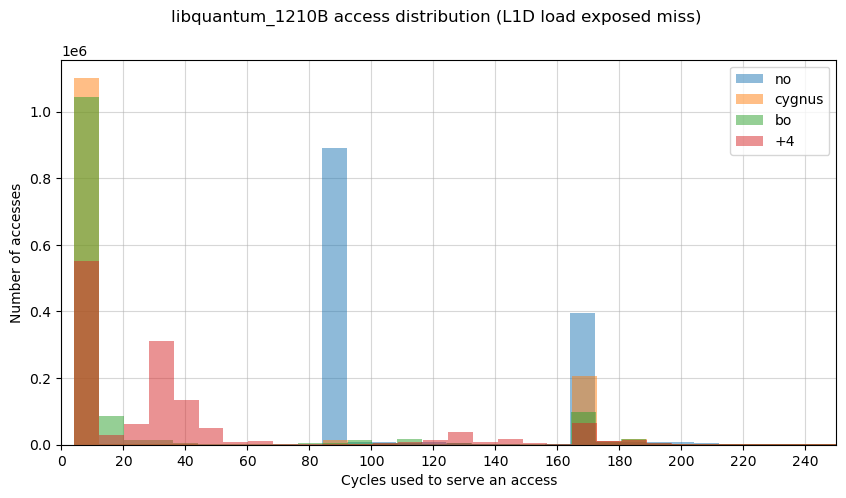

In [6]:
hist_prefetchers = defaultdict(lambda: ['no'], {
    'libquantum_1210B': ['no', 'cygnus', 'bo', '+4']
})

# hist_colors = defaultdict(lambda: None, {
#     'no': 'C0',
#     'cygnus': 'C1',
#     'bo': 'C0',
#     '+1': 'C1',
#     '+2': 'C2',
#     '+4': 'C1',
#     '+8': 'C3',
# })

for trace in traces:
    plot_histogram(data, trace, 'L1D', 'exposed_miss_LOAD', 
                   prefetchers=hist_prefetchers[trace],
                   #colors=hist_colors,
                   figsize=(10, 5))

### Head CDF
**x-axis**: Cycles

**y-axis**: Percent/number of accesses taking $x$ or **fewer** cycles to serve.

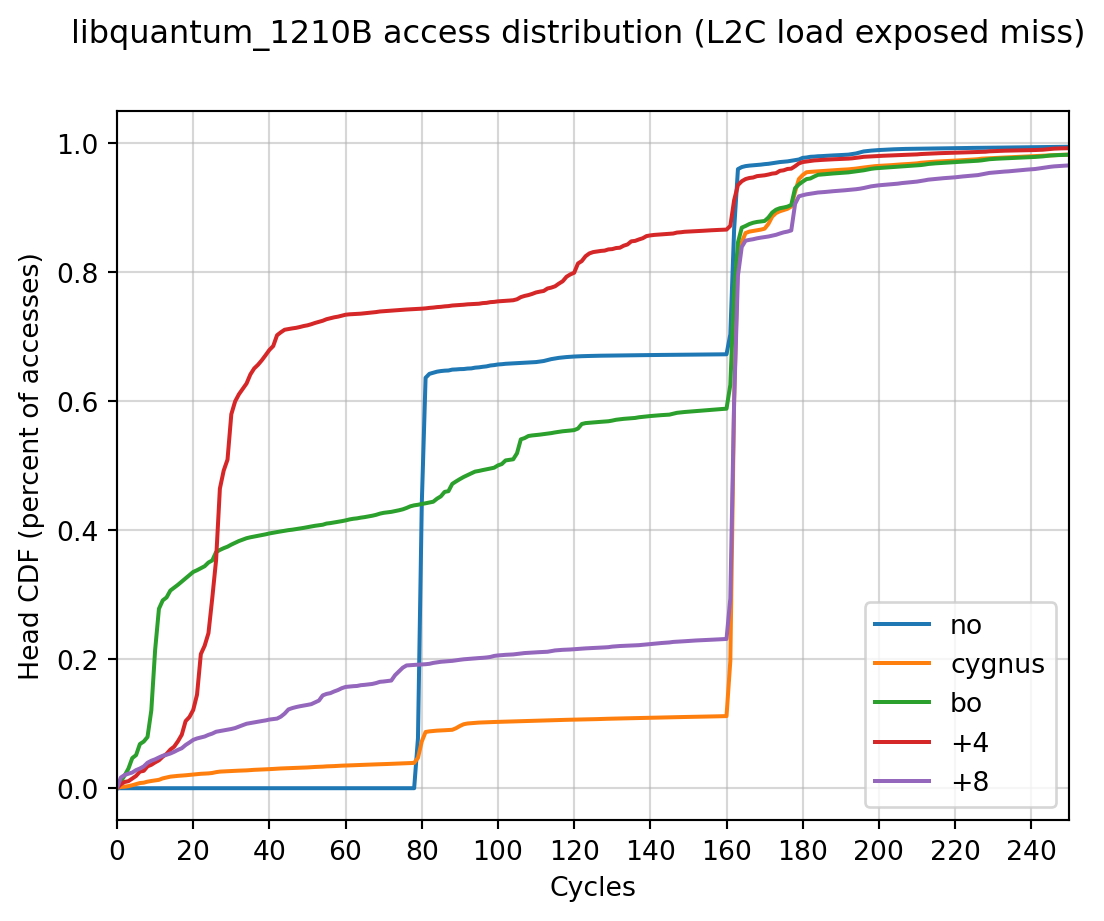

In [7]:
cdf_prefetchers = defaultdict(lambda: ['no'], {
    'libquantum_1210B': ['no', 'cygnus', 'bo', '+4', '+8'],
})

# colors = defaultdict(lambda: None, {
#     'no': 'C0',
#     'cygnus': 'C1',
#     'bo': 'C2',
#     '+1': 'C4',
#     '+2': 'C5',
#     '+4': 'C4',
#     '+8': 'C3',
# })
                         
for trace in traces:
    plot_cdf(data, trace, 'L2C', 'exposed_miss_LOAD', 
             prefetchers=cdf_prefetchers[trace],
             cdf_generator=access_cdf,
             normalize=True, tail=False,
             dpi=192)#, colors=colors)

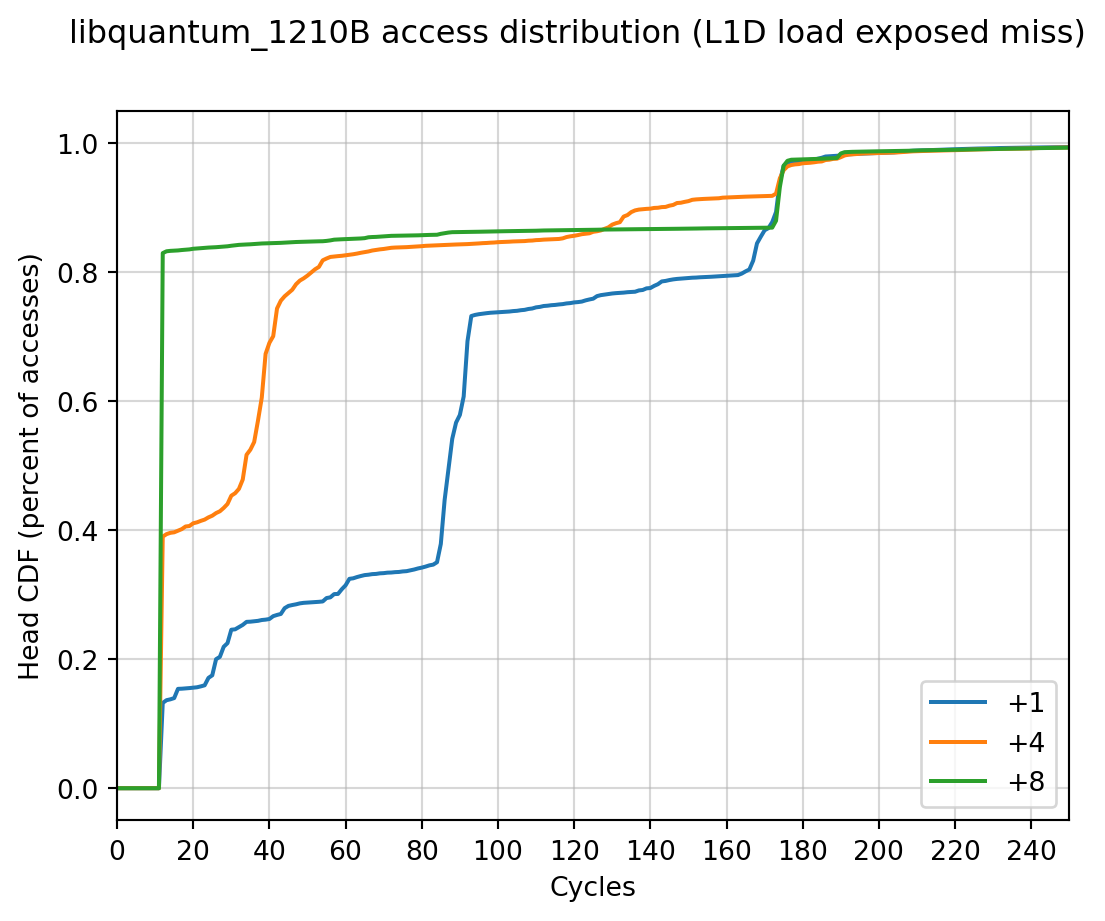

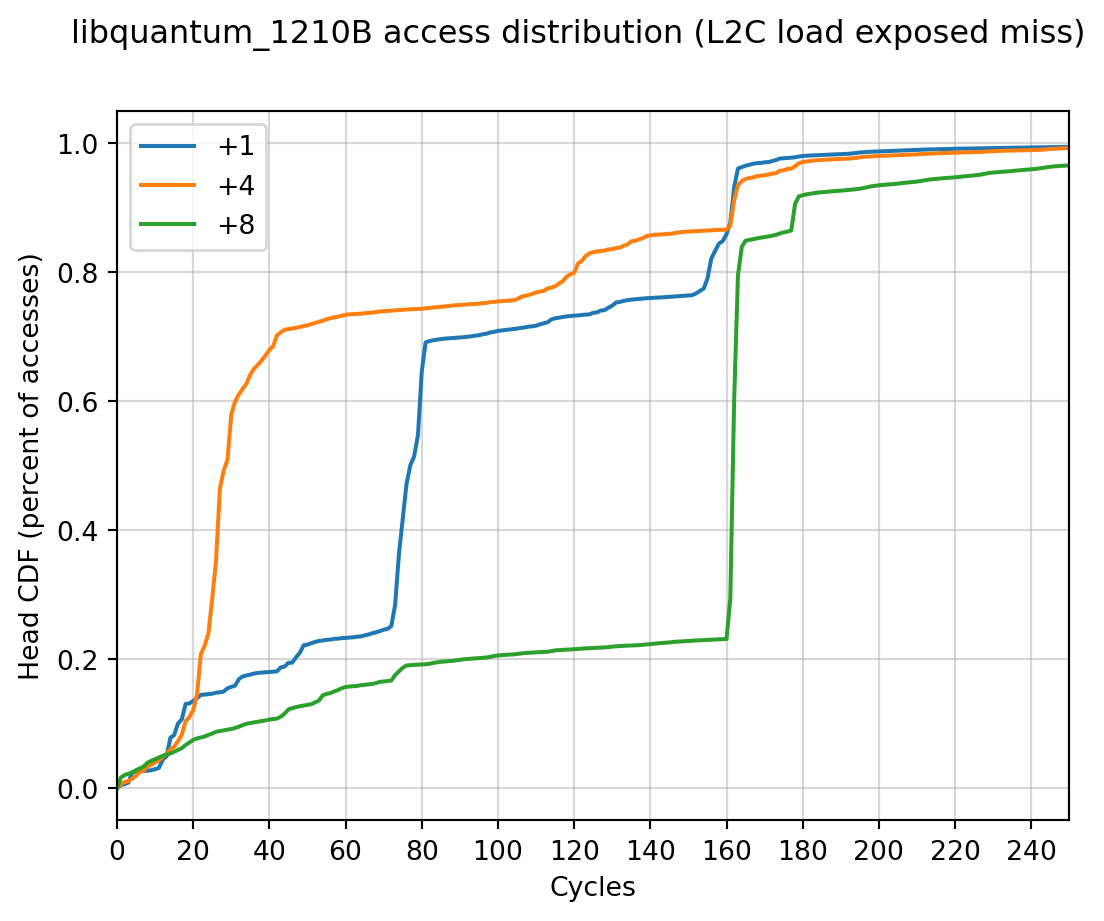

In [8]:
fixed_offset_prefetchers = ['+1', '+4', '+8']
for trace in traces:
    plot_cdf(data, trace, 'L1D', 'exposed_miss_LOAD', 
             prefetchers=fixed_offset_prefetchers,
             cdf_generator=access_cdf,
             normalize=True, tail=False,
             dpi=192)#, colors=colors)
    plot_cdf(data, trace, 'L2C', 'exposed_miss_LOAD', 
             prefetchers=fixed_offset_prefetchers,
             cdf_generator=access_cdf,
             normalize=True, tail=False,
             dpi=192)#, colors=colors)

### Tail CDF
**x-axis**: Cycles

**y-axis**: Percent/number of accesses taking $x$ or **more** cycles to serve.

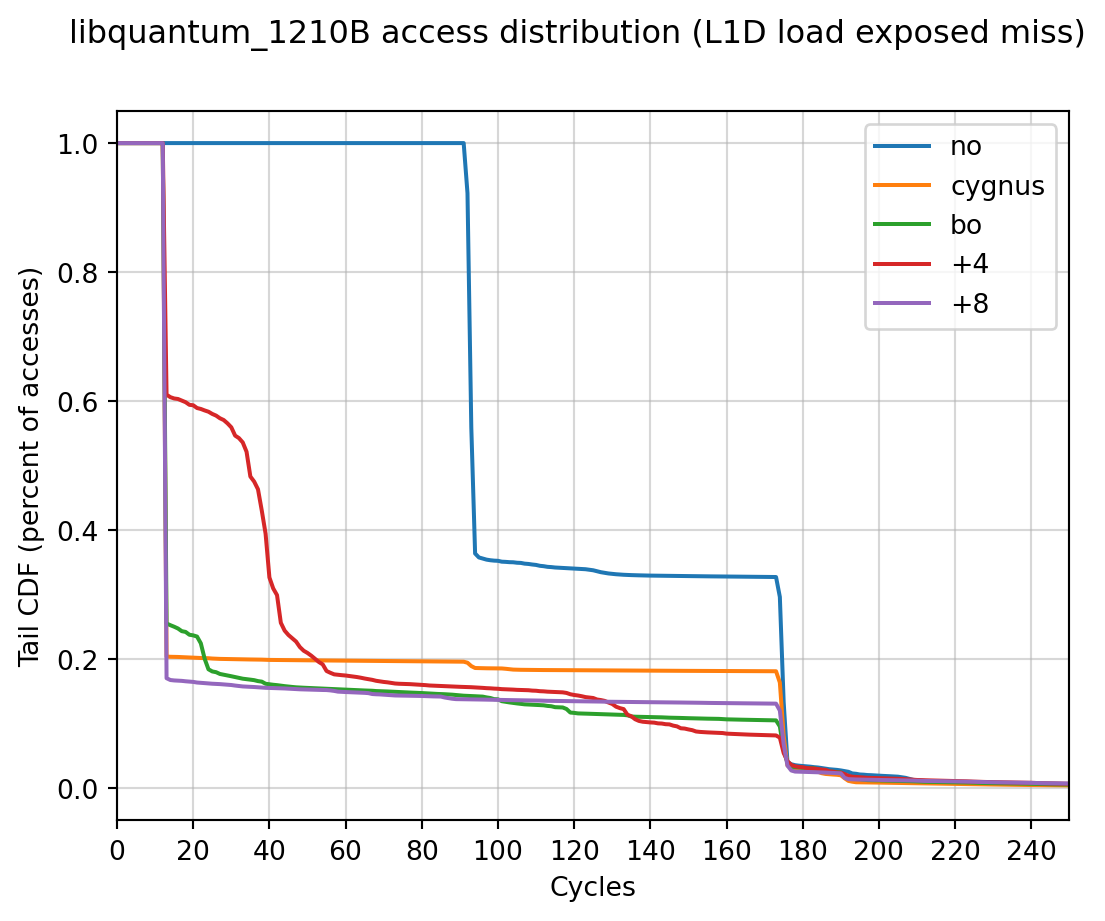

In [9]:
for trace in traces:
    plot_cdf(data, trace, 'L1D', 'exposed_miss_LOAD', 
             prefetchers=cdf_prefetchers[trace],
             cdf_generator=access_cdf,
             normalize=True, tail=True,
             dpi=192)#, colors=colors)

## Cycle distribution
How are memory access cycles distributed among access **cycles**?

i.e. account for not only each access, but how many cycles each access takes.


### Histogram

In [10]:
for trace in traces:
    plot_histogram(data, trace, 'L1D', 'exposed_miss_LOAD', 
                   prefetchers=hist_prefetchers[trace],
                   data_generator=(lambda data : data.values * data.index),
                   colors=hist_colors,
                   unit='cycle',
                   y_label='Number of cycles',
                   figsize=(10, 5))

NameError: name 'hist_colors' is not defined


### Head CDF
**x-axis**: Cycles

**y-axis**: Percent/number of cycles spent servicing loads taking $x$ or **less** cycles.

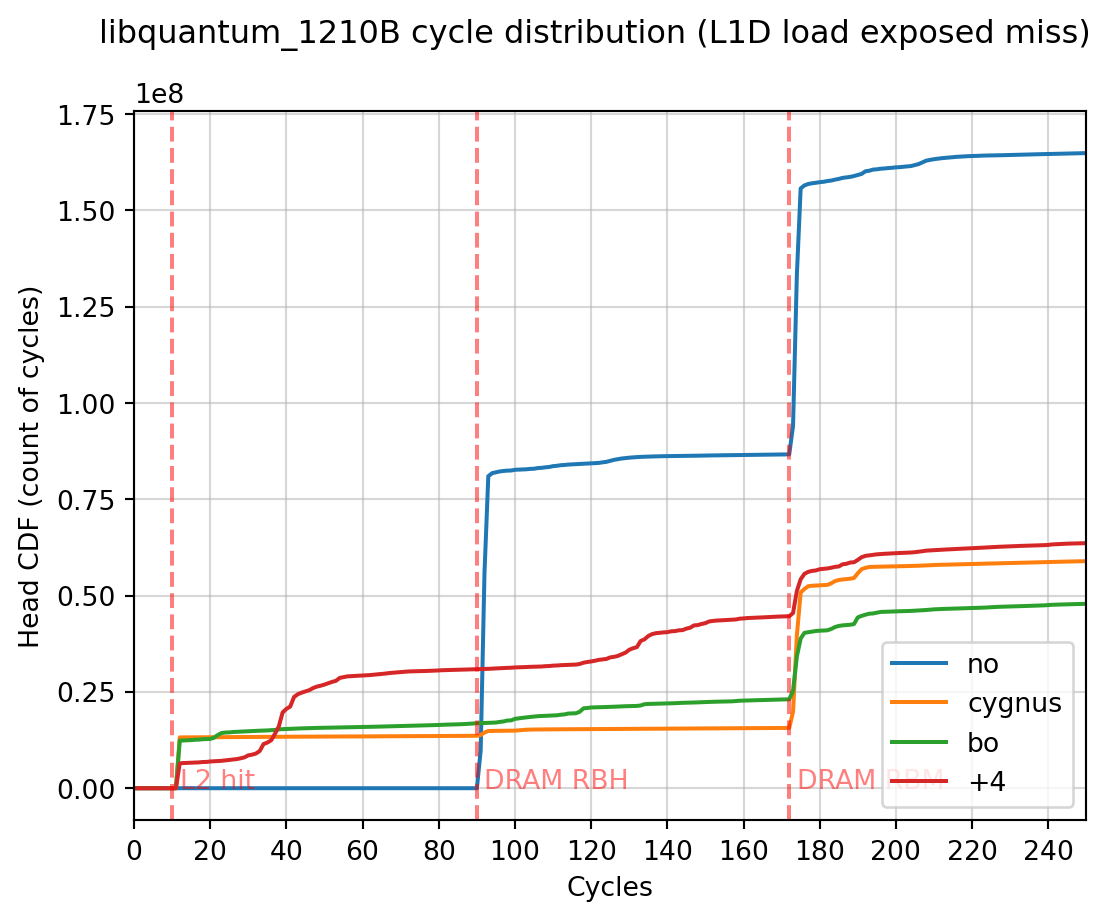

In [ ]:
for trace in traces:
    plot_cdf(data, trace, 'L1D', 'exposed_miss_LOAD', 
             prefetchers=cdf_prefetchers[trace],
             cdf_generator=cycle_cdf,
             unit='cycle',
             normalize=False, tail=False,
             dpi=192)#, colors=colors)

### Tail CDF
**x-axis**: Cycles

**y-axis**: Percent/number of cycles spent servicing loads taking $x$ or **more** cycles.

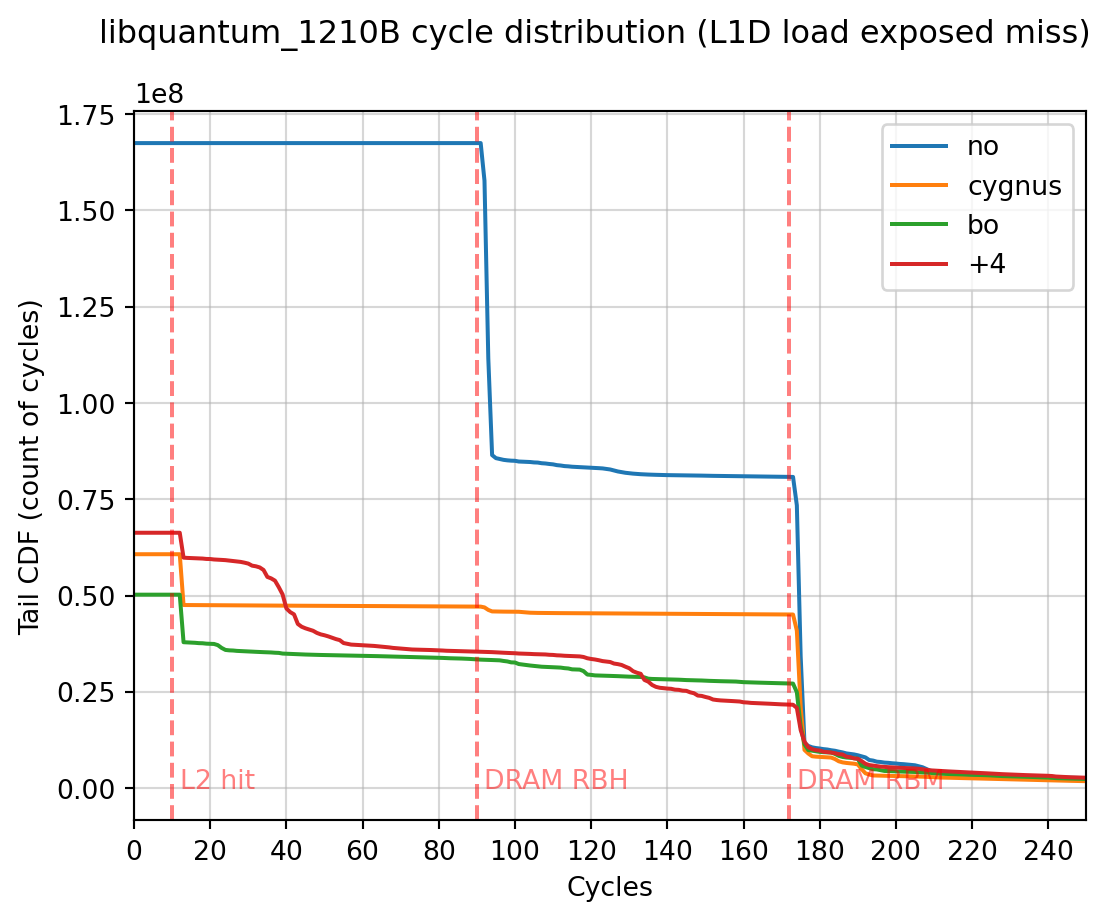

In [ ]:
for trace in traces:
    plot_cdf(data, trace, 'L1D', 'exposed_miss_LOAD', 
             prefetchers=cdf_prefetchers[trace],
             cdf_generator=cycle_cdf,
             unit='cycle',
             normalize=False, tail=True,
             dpi=192)#, colors=colors)

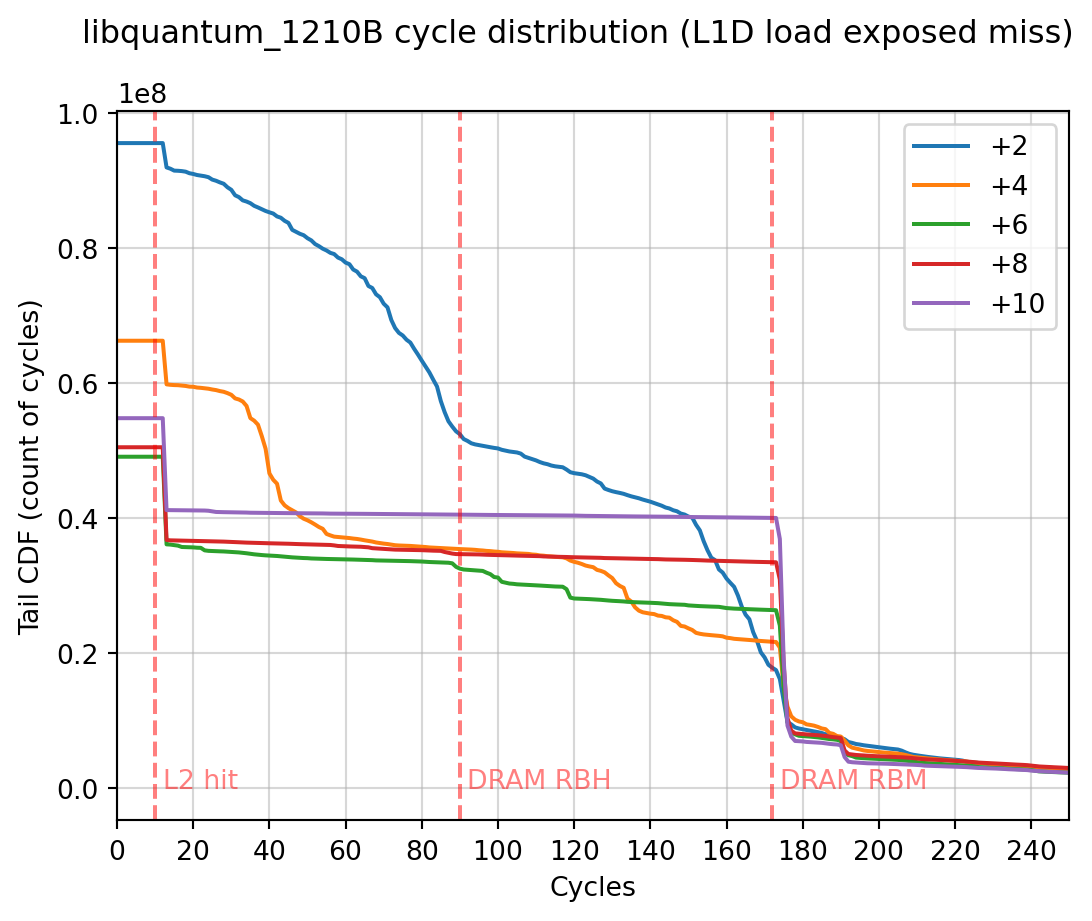

In [ ]:
for trace in traces:
    plot_cdf(data, trace, 'L1D', 'exposed_miss_LOAD', 
             prefetchers=fixed_offset_prefetchers,
             cdf_generator=cycle_cdf,
             unit='cycle',
             normalize=False, tail=True,
             dpi=192)#, colors=colors)